In [150]:
# 1. 📦 Imports
# Cell 1: Import Libraries
# 🧪 Section 1: Load Libraries and Dataset
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("metadata.csv")
df.head()



,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
# 🔍 Section 2: Prepare Features and Target for Classification
# Define target: expert1_grade = (0 = healthy, 1 = suspect, 2 = glaucomatous)
target_column = 'expert1_grade'

# Drop rows with missing target
df = df.dropna(subset=[target_column])

# Select numeric features only
features = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target_column], errors='ignore')
X = features.fillna(0)
y = df[target_column]

# Encode labels if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    joblib.dump(le, 'label_encoder.pkl')


Random Forest Classification Report:

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.87      0.87      0.87        15

    accuracy                           0.81        21
   macro avg       0.77      0.77      0.77        21
weighted avg       0.81      0.81      0.81        21



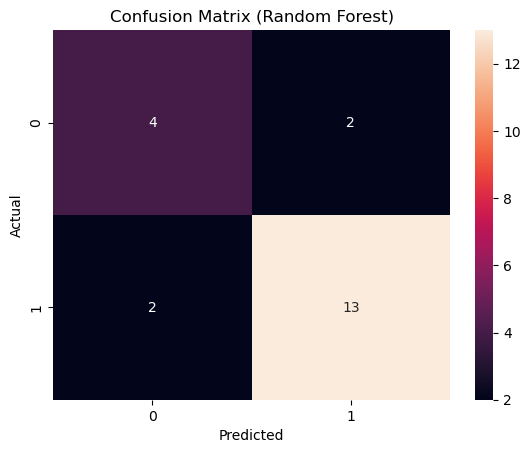

SVM Classification Report:

              precision    recall  f1-score   support

         0.0       0.62      0.83      0.71         6
         1.0       0.92      0.80      0.86        15

    accuracy                           0.81        21
   macro avg       0.77      0.82      0.79        21
weighted avg       0.84      0.81      0.82        21



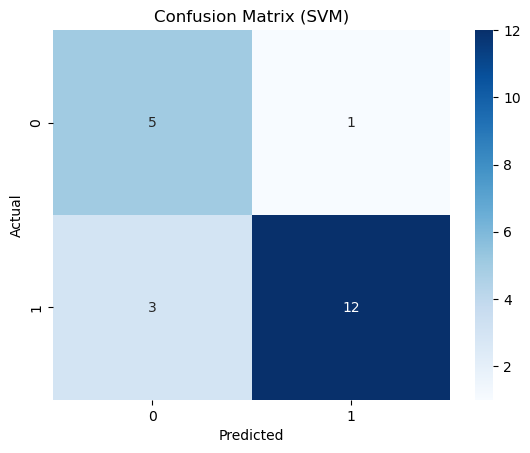

In [154]:
# 🤖 Section 3: Train Classification Models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'random_forest_model.pkl')

# SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'svm_model.pkl')

# Evaluation - Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation - SVM
y_pred_svm = svm_model.predict(X_test)
print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


C:\Users\samin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


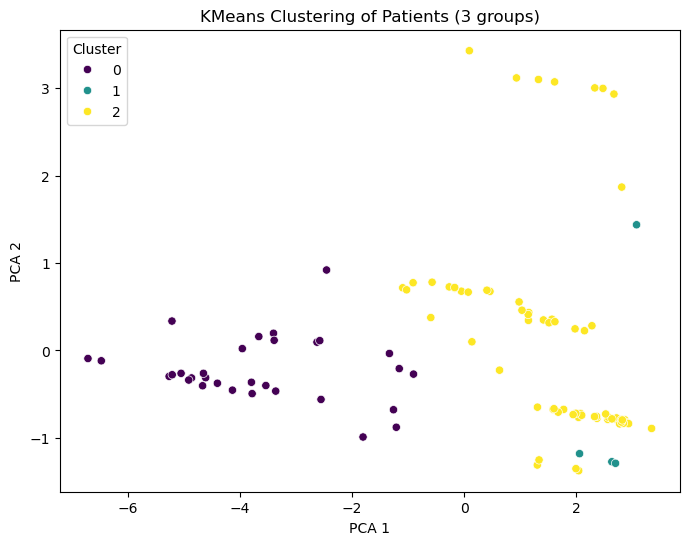

['kmeans_cluster_model.pkl']

In [156]:
# 🔬 Section 4: Clustering for Progression Prediction / Stage Tracking
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df['cluster'] = cluster_labels

# Visualize clusters using PCA or t-SNE
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=df['cluster'], palette='viridis')
plt.title("KMeans Clustering of Patients (3 groups)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# Optional: Save cluster model
joblib.dump(kmeans, 'kmeans_cluster_model.pkl')


